In [1]:
# System modules
import pickle
import folium
from folium import plugins
import numpy as np
import pandas as pd
from time import time
from datetime import datetime
import matplotlib.pyplot as plt

# User modules
from domain.base import DataRequest
import domain.fs_engine as netatmo
from domain.elevation_service import (
    ElevationServiceConnector
)

from helpers.utils import (
    get_station_coordinates,
    add_station_elevations,
    select_near
)
import helpers.knmi_obs_ingest as knmi


In [2]:
# Read station meta data
with open('data/stations.csv', 'r') as f:
    station_meta_data = pd.read_csv(f)
print("Loaded meta data for %d stations." % len(station_meta_data))

Loaded meta data for 13254 stations.


In [114]:
# Defining a request for the Netherlands
request = DataRequest()
start_dt = datetime(2016, 3, 25, 0, 0)
# end_dt = datetime(2016, 3, 25, 6, 0)
end_dt = datetime(2016, 4, 13, 15, 0)
request.start_datetime = start_dt
request.end_datetime = end_dt
request.time_resolution = 10
request.region = (53.680, 2.865, 50.740, 7.323)
print("Request defined from %s to %s" % (start_dt, end_dt))

Request defined from 2016-03-25 00:00:00 to 2016-04-13 15:00:00


In [115]:
# Load KNMI 10-minute observations from disk.
print("Querying KNMI observation data..")
knmi_path = 'X:/netatmo/obs/'
knmi_fsengine = knmi.FileSystemEngine(knmi_path)
obs_data = knmi_fsengine.query(request)

Querying KNMI observation data..
Loading 2831 files in total.
File 1: o03242340.txt
File 2: o03242350.txt
File 3: o03250000.txt
File 4: o03250010.txt
File 5: o03250020.txt
File 6: o03250030.txt
File 7: o03250040.txt
File 8: o03250050.txt
File 9: o03250100.txt
File 10: o03250110.txt
File 11: o03250120.txt
File 12: o03250130.txt
File 13: o03250140.txt
File 14: o03250150.txt
File 15: o03250200.txt
File 16: o03250210.txt
File 17: o03250220.txt
File 18: o03250230.txt
File 19: o03250240.txt
File 20: o03250250.txt
File 21: o03250300.txt
File 22: o03250310.txt
File 23: o03250320.txt
File 24: o03250330.txt
File 25: o03250340.txt
File 26: o03250350.txt
File 27: o03250400.txt
File 28: o03250410.txt
File 29: o03250420.txt
File 30: o03250430.txt
File 31: o03250440.txt
File 32: o03250450.txt
File 33: o03250500.txt
File 34: o03250510.txt
File 35: o03250520.txt
File 36: o03250530.txt
File 37: o03250540.txt
File 38: o03250550.txt
File 39: o03250600.txt
File 40: o03250610.txt
File 41: o03250620.txt
File

In [116]:
# Dump observation data to a single file for caching.
with open('data/netherlands_obs_3-25_4-15.pkl', 'wb') as f:
    pickle.dump(obs_data, f)

In [117]:
# Load cached observations.
load_start = time()
with open('data/netherlands_obs_3-25_4-15.pkl', 'rb') as f:
    obs_data = pickle.load(f)
print("Done loading observations (%fs)." % (time() - load_start))

Done loading observations (107.005728s).


In [6]:
# Query netatmo data from disk.
netatmo_path = 'X:/netatmo/data/'
print("Querying NetAtmo file system engine..")
netatmo_fsengine = netatmo.FileSystemEngine(netatmo_path)
response = netatmo_fsengine.query(request)
data_map = response.data_map
print("%d stations loaded." % len(data_map))

Querying NetAtmo file system engine..
Loading 37 files in total.
File 1: netatmo_20160325_0000.json.gz
Total number of stations:           11631
Points in file:                     141777
Points out of region:               130146
Points ignored:                     358
New stations:                       11631
Points added to dataset:            11273

File 2: netatmo_20160325_0010.json.gz
Total number of stations:           11631
Points in file:                     141777
Points out of region:               130146
Points ignored:                     11631
New stations:                       0
Points added to dataset:            0

File 3: netatmo_20160325_0020.json.gz
Total number of stations:           11636
Points in file:                     141703
Points out of region:               130081
Points ignored:                     393
New stations:                       5
Points added to dataset:            11229

File 4: netatmo_20160325_0030.json.gz
Total number of stations:         

KeyboardInterrupt: 

In [ ]:
# Dump NetAtmo data to a single file for caching.
with open('data/netherlands_3-25_4-15.pkl', 'wb') as f:
    pickle.dump(data_map, f)

In [7]:
# Load cached NetAtmo data.
with open("data/netherlands_3-25_4-15.pkl", "rb") as f:
    data_map = pickle.load(f)

In [121]:
# Select stations at or near a specified station id
query_station_id = 6286  # WMO station to search nearby
radius = 10000  # Search radius in meters
query_station_location = station_meta_data.loc[station_meta_data.stationId == query_station_id, ["latitude", "longitude"]]
print("Query station location: lat %f, lon %f" % (query_station_location.latitude, query_station_location.longitude))

near_station_map = select_near(
                                data_map, 
                                query_station_location.latitude, query_station_location.longitude,
                                radius=radius
                              )

print("%d stations near WMO station %d." % (len(near_station_map), query_station_id))
netatmo.resample_and_interpolate(near_station_map, request.time_resolution)
print("Done.")

Query station location: lat 53.194447, lon 7.149167
4 stations near WMO station 6286.
0 / 4 stations processed..
Done.


In [122]:
# Construct a map plot of the query station and its found nearby NetAtmo stations.
query_lat = list(query_station_location.latitude.values)
query_lon = list(query_station_location.longitude.values)
map_1 = folium.Map(
    query_lat + query_lon,
    zoom_start=13, 
    tiles='stamentoner'
)
# Draw point of interest
folium.Marker(query_lat + query_lon, icon=folium.Icon(color='red')).add_to(map_1)

# Draw search radius
folium.CircleMarker(
    query_lat + query_lon,
    radius=radius,
    color='#3186cc',
    fill_color='#C7DDF0',
   ).add_to(map_1)

for station_id in near_station_map:
    station = near_station_map[station_id]
    folium.Marker([station.latitude, station.longitude], popup=station_id).add_to(map_1)
map_1

Station 6286 has 2831 observations for element temperature


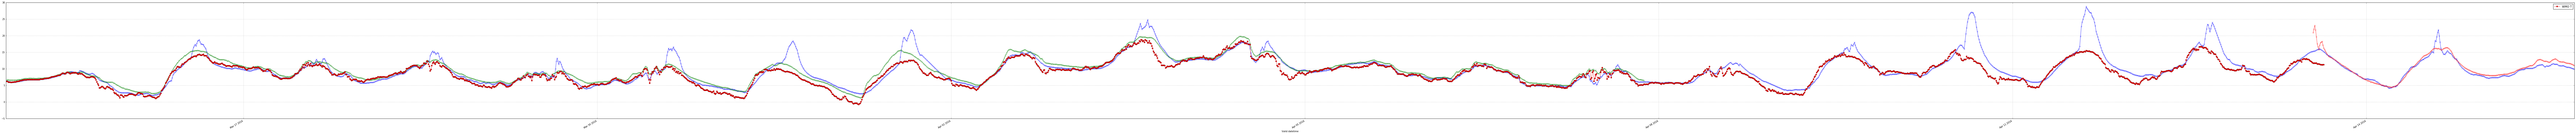

In [123]:
# Plotting of timeseries of nearby NetAtmo stations.
%matplotlib inline
fig, ax = plt.subplots(1, figsize=(200, 10))
plt.xlabel("Valid datetime")

element = 'temperature'

gp = obs_data.groupby('station_id')
wmo_obs = gp.get_group(query_station_id)
if element == 'pressure':
    knmi_name = 'p0'
elif element == 'temperature':
    knmi_name = 'ta'
elif element == 'humidity':
    knmi_name = 'rh'
wmo_obs_el = wmo_obs[wmo_obs.element_name==knmi_name]
print("Station %d has %d observations for element %s" % (query_station_id, len(wmo_obs_el), element))

for station_id in near_station_map:
    station = near_station_map[station_id].thermo_module
    # Drop nan-columns
    station.dropna(axis=1, inplace=True)
#     print(station)
    if element in station:
        p = plt.plot(station.index.values, station[element].values, marker='x', label=None)
# Plot WMO
ax.plot(wmo_obs_el['valid_datetime'].values, wmo_obs_el['value'].values, color='red', marker='o', label='WMO T')
# ax.set_xlim([wmo_obs_el['va']])
# wmo_obs_qg = wmo_obs[wmo_obs.element_name=='qg']
# ax2 = ax.twinx()
# ax2.plot(wmo_obs_qg['valid_datetime'].values, wmo_obs_qg['value'].values, color='green', marker='o', label='WMO QG')
# ax2.set_ylabel("Incoming radiation")
plt.grid('on')

fig.autofmt_xdate()
ax.legend(numpoints=1)
plt.show()
